# Интеллектуальные методы обработки видео

In [1]:
import pandas as pd

In [8]:
c = {'a': [1, 2], 'b' : [4, 3]}
d = {'e': [0, 0], 'ww' : [4444, 44444444]}
d = pd.DataFrame(d)
c = pd.DataFrame(c)
c['a'] = d.ww
c.head()

,a,b
0,4444,4
1,44444444,3


In [14]:
# GRADED FUNCTION: scene_change_detector
import joblib
def scene_change_detector(frames, with_vis=False, cuts = None):
    #print(threshold, Sobel_t, hist_threshold)
    
    scene_changes = []
    vis = []
    metric_values = []
    
    ### START CODE HERE ###
    # Ваши внешние переменные
    prev_frame = None
    metric_values1 = []
    #model = joblib.load('model_new.pkl')
    def pixel_metric(frame, prev_frame):
        return np.mean((frame.astype(np.int32) - prev_frame) ** 2)
    def brightness_metric(frame, prev_frame):
        return np.abs(np.mean(frame) - np.mean(prev_frame))
    def brightness_differense_metric(frame, prev_frame):
        return np.abs(np.mean(frame - prev_frame))
    def std_metric(frame, prev_frame):
        return np.abs(np.std(frame) - np.std(prev_frame))
    def std_diff_metric(frame, prev_frame):
        return np.abs(np.std(frame - prev_frame))
    def hist_metric(frame, prev_frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        prev_frame = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
        hist1 = cv2.calcHist([frame], [0], None, [64], [1, 64])
        hist2 = cv2.calcHist([prev_frame], [0], None, [64], [1, 64])
        return np.abs((hist1 - hist2)).ravel()
    def hist_corel_metric(frame, prev_frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        prev_frame = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
        hist1 = cv2.calcHist([frame], [0], None, [64], [1, 64])
        hist2 = cv2.calcHist([prev_frame], [0], None, [64], [1, 64])
        return cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
    def hist_feature_metric(frame, prev_frame, gray=False, crop_x = 10, crop_y = 10):
        height, width = 1, 1
        if gray == False:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            prev_frame = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
            height, width = frame.shape
        else:
            height, width = frame.shape
        cut = np.zeros((crop_x * crop_y, 4))
        ind = 0
        for ih in range(crop_y):
            for iw in range(crop_x):
                x = width//crop_x * iw 
                y = height//crop_y * ih
                h = height // crop_y
                w = width // crop_x
                tmp_frame = frame[y:y+h, x:x+w]
                tmp_prev_frame = prev_frame[y:y+h, x:x+w]
                a = cv2.calcHist([tmp_frame], [0], None, [64], [1, 64])
                b = cv2.calcHist([tmp_prev_frame], [0], None, [64], [1, 64])
                cut[ind][0] = cv2.compareHist(a, b, cv2.HISTCMP_CORREL)
                cut[ind][1] = cv2.compareHist(a, b, cv2.HISTCMP_INTERSECT)
                cut[ind][2] = cv2.compareHist(a, b, cv2.HISTCMP_KL_DIV)
                tmp_frame = tmp_frame / 255
                tmp_prev_frame = tmp_prev_frame / 255
                tmp = brightness_metric(tmp_frame, tmp_prev_frame) / 4
                std1 = np.var(tmp_frame) / 2
                std2 = np.var(tmp_prev_frame)
                if std1 == 0 or std2 == 0:
                    cut[ind][3] = (tmp + std1 * std2) ** 2 / 0.112
                else:
                    cut[ind][3] = (tmp + std1 * std2) ** 2 / (std1 * std2 * 2)
                ind += 1
        return list(np.mean(cut, axis = 0))
    def cos_metric(frame, prev_frame):
        tmp1 = np.sum(frame * prev_frame)
        tmp = np.sqrt(np.sum(prev_frame**2))
        tmp = np.sqrt(tmp * np.sum(frame**2))
        if tmp == 0:
            tmp = tmp1 / 0.0123
        else:
            tmp = tmp1 / tmp
        return tmp
    def hist_eq(frame):
        lab = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(3,3))
        cl = clahe.apply(l)
        limg = cv2.merge((cl,a,b))
        final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
        return final
    def laplasian(frame):
        frame1 = cv2.GaussianBlur(frame, (3, 3), 0)
        frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
        frame1 = cv2.Laplacian(frame1, cv2.CV_16S, ksize=5)
        abs_dst1 = cv2.convertScaleAbs(frame1)
        return abs_dst1
    ###  END CODE HERE  ###
    
    for idx, frame in tqdm(enumerate(frames), leave=False):
        ### START CODE HERE ###
        # Основная часть вашего алгоритма
        if prev_frame is not None:
            fr = frame
            fr_prev = prev_frame
            metrics = []
            
            metrics.append(cos_metric(fr, fr_prev))
            
            
            
            fr = hist_eq(frame)
            fr_prev = hist_eq(prev_frame)
            
            metrics.append(cos_metric(fr, fr_prev))
            
            
            
            ans = 0
        prev_frame = frame
        ###  END CODE HERE  ###
    return scene_changes, vis, metric_values#, metric_values1, metric_values2

In [15]:
for vid_name in tqdm(['03', '04', '05', '07', '08', '10', '14', '17', '21', '22'] ,leave=False):
    final_metrics = ['cos',       'cos_eq']
    dataset = pd.DataFrame(columns=final_metrics + ['answer'])

    frames = read_video(os.path.join('train_dataset', 'video', f'{vid_name}.mp4'))
    cuts = load_json_from_file(os.path.join('train_dataset', 'gt', f'{vid_name}.json'))['cut']
    scene_changes, vis, metric_values = scene_change_detector(frames, with_vis=True, cuts=cuts)
    dataset.to_csv(f'tmp_new/video_{vid_name}_dataset.csv',index=False)

/home/evgenij/miniconda3/envs/evg/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/home/evgenij/miniconda3/envs/evg/lib/python3.7/site-packages/ipykernel_launcher.py:96: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


## Задание 1. Scene Change Detector

### Обязательно к прочтению

**Внимание!**

Opencv содержит очень много высокоуровневых функций обработки изображений (например, некоторые алгоритмы компенсации движения, отслеживания объектов, распознавания образов). Использование данной библиотеки в данном задании ограничивается:
* считыванием входного видео
* преобразованием его кадров в другие цветовые пространства
* использованием свёрток Собеля

Использовать библиотеку numpy можно без ограничений.

Если вы хотите использовать функции обработки изображений и видео из другой библиотеки, то оговорите использование этой функции в чате курса.

### Описание входных данных

Выборка для тренировки лежит https://titan.gml-team.ru:5003/sharing/yX8enupJV

Данные о каждом видео лежат в файле *train_dataset\info.json*. Это список из словарей, каждый словарь содержит информацию о расположении видео, о расположении ответов на смены сцен и содержит длину видео

In [10]:
import numpy as np
import cv2 # Для установки opencv воспользуйтесь командой в терминале conda install -c conda-forge opencv
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

In [11]:
import json
def load_json_from_file(filename):
    with open(filename, "r") as f:
        return json.load(f, strict=False)


def dump_json_to_file(obj, filename, **kwargs):
    with open(filename, "w") as f:
        json.dump(obj, f, **kwargs)

In [12]:
video_dataset = load_json_from_file('train_dataset/info.json')
video_dataset

[{'source': 'video/03.mp4', 'scene_change': 'gt/03.json', 'len': 3250},
 {'source': 'video/04.mp4', 'scene_change': 'gt/04.json', 'len': 3392},
 {'source': 'video/05.mp4', 'scene_change': 'gt/05.json', 'len': 5662},
 {'source': 'video/07.mp4', 'scene_change': 'gt/07.json', 'len': 3321},
 {'source': 'video/08.mp4', 'scene_change': 'gt/08.json', 'len': 3396},
 {'source': 'video/10.mp4', 'scene_change': 'gt/10.json', 'len': 6096},
 {'source': 'video/14.mp4', 'scene_change': 'gt/14.json', 'len': 2326},
 {'source': 'video/17.mp4', 'scene_change': 'gt/17.json', 'len': 2904},
 {'source': 'video/21.mp4', 'scene_change': 'gt/21.json', 'len': 4898},
 {'source': 'video/22.mp4', 'scene_change': 'gt/22.json', 'len': 7749}]

### Загрузка видео ###

Загрузка видео осуществляется при помощи cv2.VideoCapture. Этот код изменять и дописывать не нужно.

In [13]:
def read_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret==False:
            break
        yield frame
    cap.release()

In [5]:
frames = read_video(os.path.join('train_dataset', 'video', '03.mp4'))

Что такое frames? Это итератор на кадры видео. Чтобы пройтись по всем кадрам последовательности, воспользуйтесь следующей конструкцией:
*Аккуратно, по одной переменной frames можно пройти только один раз!*

In [6]:
for frame in tqdm(frames):
    pass
for frame in tqdm(frames): # Второй раз уже не будет итерации
    pass

/Users/av/stuf/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/Users/av/stuf/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


## Пишем свой простой детектор смен сцен ##

На данном этапе предлагается написать простой Scene Change Detector (SCD) на основе выделения характеристик кадров, подсчёта разницы между кадрами на основе данных характеристик, а также подобрать наиболее оптимальный порог для этих признаков и совместить эти признаки.
Сменой сцен в данной задаче являются только обычные мгновенные смены сцен, без дополнительных эффектов.

В качестве примера приведён простой детектор смен, который считает межкадровую разницу между кадрами.

*Важное замечание. Здесь и далее результатом алгоритма детектора сцен являются **индексы кадров начал сцен**, при этом кадры **нумеруются с 0**. Нулевой кадр в качестве ответа указывать не нужно*

<img src="Hard_cut.jpg">

In [40]:
def baseline_scene_change_detector(frames, threshold=2000, with_vis=False):
    """
    Baseline SCD

    Arguments:
    frames -- iterator on video frames
    threshold -- parameter of your algorithm (optional)
    with_vis -- saving neighboring frames at a scene change (optional)

    Returns:
    scene_changes -- list of scene changes (idx of frames)
    vis -- list of neighboring frames at a scene change (for visualization)
    metric_values -- list of metric values (for visualization)
    """
    
    def pixel_metric(frame, prev_frame):
        # Базовое расстояние между кадрами - среднеквадратическая ошибка между ними
        return np.mean((frame.astype(np.int32) - prev_frame) ** 2)

    scene_changes = []
    vis = []
    metric_values = []
    prev_frame = None
    for idx, frame in tqdm(enumerate(frames), leave=False):
        # frame - это кадр
        # idx - это номер кадра
        if prev_frame is not None:
            # Находим расстояние между соседними кадрами
            metric_value = pixel_metric(frame, prev_frame)
            if metric_value > threshold:
                scene_changes.append(idx)
                if with_vis:
                    # Кадры в памяти занимают много места, поэтому сохраним лишь первые 100 срабатываний
                    if len(vis) < 100:
                        vis.append([prev_frame, frame])
            metric_values.append(metric_value)
        else:
            metric_values.append(0)
        prev_frame = frame
    return scene_changes, vis, metric_values

In [41]:
frames = read_video(os.path.join('train_dataset', 'video', '03.mp4'))
cuts_base = load_json_from_file(os.path.join('train_dataset', 'gt', '03.json'))['cut']
scene_changes_base, vis_base, metric_values_base = baseline_scene_change_detector(frames, with_vis=True)

/home/jood/vg/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Посмотрим визуально, насколько сильно алгоритм ошибается, а также на значения метрики

In [42]:
def visualize_metric_error(frame, prev_frame, value):
    fig = plt.figure(figsize=(16,4))
    plt.suptitle('Значение метрики на текущем кадре: {:.4f}'.format(value), fontsize=24)
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(prev_frame[:,:,::-1])
    ax.set_title("Предыдущий кадр", fontsize=18)
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(frame[:,:,::-1])
    ax.set_title("Текущий кадр", fontsize=18)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.subplots_adjust(top=0.80)

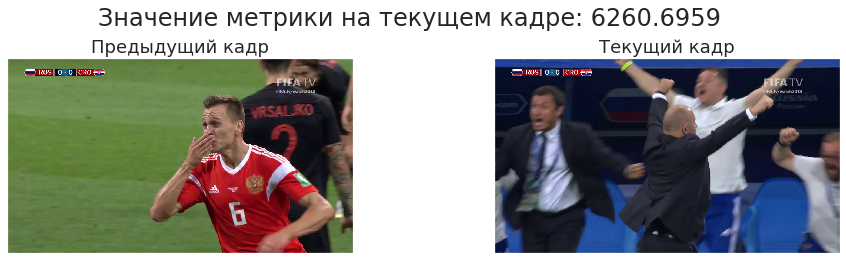

In [43]:
idx = 1
visualize_metric_error(vis_base[idx][0], vis_base[idx][1], metric_values_base[scene_changes_base[idx]])
# смена сцен

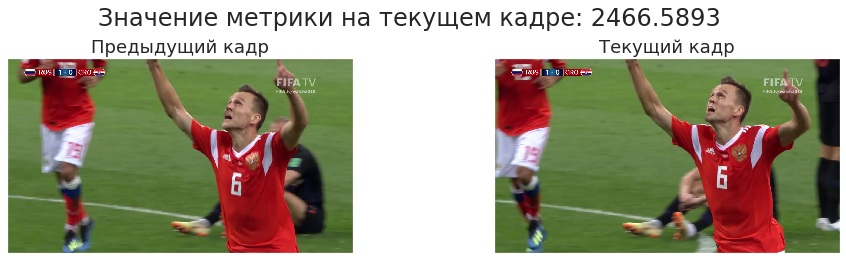

In [44]:
idx = 10
visualize_metric_error(vis_base[idx][0], vis_base[idx][1], metric_values_base[scene_changes_base[idx]])
# ошибается, это не смена сцен

In [45]:
def visualize_metric_values(metric_values, threshold, cuts = None):
    sns.set()
    plt.figure(figsize=(16, 8))
    plt.plot(metric_values, label='Значение метрики на кадрах')
    plt.xlabel('Номер кадра')
    plt.ylabel('Значение метрики')
    plt.hlines(y=threshold, xmin=0, xmax=len(metric_values), linewidth=2, color='r', label='Пороговое значение')
    
    if cuts is not None:
        for cut in cuts:
            plt.axvline(x=cut, color='k', linestyle=':', linewidth=0.5, label='Смена сцены')

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()

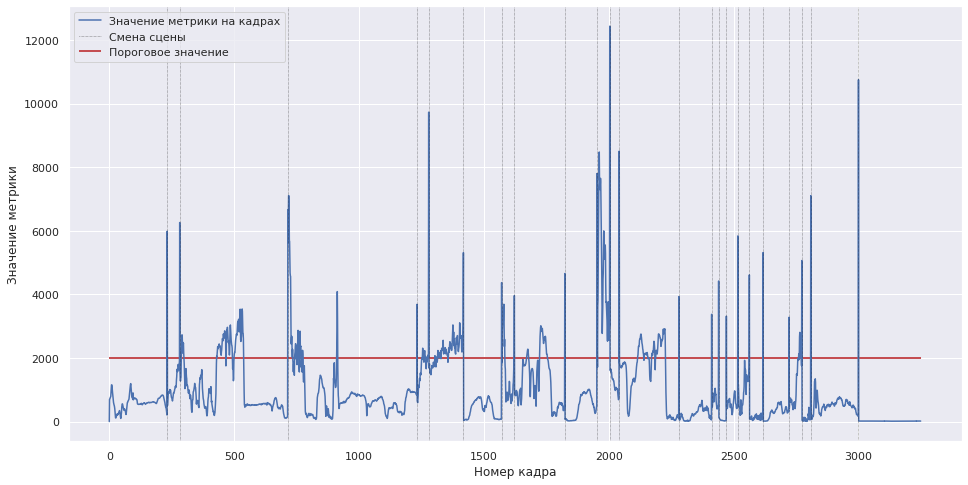

In [46]:
visualize_metric_values(metric_values_base, 2000, cuts_base)

**Как видим, очень плохо подобран порог, да и сам признак, похоже, сильно зашумлён. Попробуйте что-то своё!**

## Ваше решение ##

* В качестве решения вы должны прикрепить функцию ниже. Все пороги должны быть указаны внутри функции.  
Т.е. должен быть возможен вызов:  
`scene_changes, vis, metric_values = scene_change_detector(frames)`  
* Строку (# GRADED FUNCTION: [function name]) менять **нельзя**. Она будет использоваться при проверке вашего решения.
* Ячейка должна содержать только **одну** функцию.

In [23]:
# GRADED FUNCTION: scene_change_detector

def scene_change_detector(frames, with_vis=False, Tb = 0.5, Tm = 0.05, a0 = 0.01, a1 = 0.1, b0 = 1, b1 = 0.1, b2 = 0.108):
    """
    Baseline SCD

    Arguments:
    frames -- iterator on video frames
    threshold -- parameter of your algorithm (optional)
    with_vis -- saving neighboring frames at a scene change (optional)

    Returns:
    scene_changes -- list of scene changes (idx of frames)
    vis -- list of neighboring frames at a scene change (for visualization)
    metric_values -- list of metric values (for visualization)
    """
    numof_blocks = 10
    k = 6
    buf_next_frames = [[],[]]
    buf_prev_frames = [[],[]]
    import math
    
    def std_metric(block, prev_block):
        return math.fabs(np.std(block) - np.std(prev_block))/255
    def mean_brightness_metric(block, prev_block):
        return math.fabs(np.mean(block) - np.mean(prev_block))/255
    
    def lapl(frame):
        src = cv2.GaussianBlur(frame, (3, 3), 0)
        src_gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
        dst = cv2.Laplacian(src_gray, cv2.CV_16S, ksize=5)
        abs_dst = cv2.convertScaleAbs(dst)
        return abs_dst
    
    def delta_fun(cur_frame, prev_frame):
        delta_horiz = 0 
        delta_vert = 0
        block_width = cur_frame.shape[1]//numof_blocks
        block_height = cur_frame.shape[0]//numof_blocks
        for i in range(numof_blocks):
            for j in range(numof_blocks):
                block_ij = cur_frame[i*block_height:(i+1)*block_height,j*block_width:(j+1)*block_width]
                prev_block_ij = prev_frame[i*block_height:(i+1)*block_height,j*block_width:(j+1)*block_width]
                if j < numof_blocks - 1:
                    block_ij1 = cur_frame[i*block_height:(i+1)*block_height,(j+1)*block_width:(j+2)*block_width]
                    prev_block_ij1 = prev_frame[i*block_height:(i+1)*block_height,(j+1)*block_width:(j+2)*block_width]
                    delta_horiz += math.fabs((np.mean(block_ij) - np.mean(block_ij1)) - (np.mean(prev_block_ij) - np.mean(prev_block_ij1)))
                if i < numof_blocks - 1:
                    block_i1j = cur_frame[(i+1)*block_height:(i+2)*block_height,j*block_width:(j+1)*block_width]
                    prev_block_i1j = prev_frame[(i+1)*block_height:(i+2)*block_height,j*block_width:(j+1)*block_width]
                    delta_vert += math.fabs((np.mean(block_ij) - np.mean(block_i1j)) - (np.mean(prev_block_ij) - np.mean(prev_block_i1j)))
        delta_horiz /= 510*numof_blocks*(numof_blocks-1)
        delta_vert /= 510*numof_blocks*(numof_blocks-1)
        return (delta_horiz+delta_vert)/2
    
    
    def E(cur_frame):
        return np.sum(cur_frame)/(255*cur_frame.shape[0]*cur_frame.shape[1])
    
    
    scene_changes = []
    vis = []
    metric_values = [[],[],[],[],[],[]]
    prev_frame = None
    last_pos = None
    
    for idx, frame in tqdm(enumerate(frames), leave=False):
        if idx < k:
            if prev_frame is None:
                buf_next_frames[0].append(frame)
                buf_next_frames[1].append(1)
            else:
                buf_next_frames[0].append(frame)
                buf_next_frames[1].append(delta_fun(frame, prev_frame))
        else:
            if len(buf_prev_frames[0]) < 1:
                buf_prev_frames[0].append(buf_next_frames[0].pop(0))
                buf_prev_frames[1].append(buf_next_frames[1].pop(0))
                buf_next_frames[0].append(frame)
                buf_next_frames[1].append(delta_fun(frame, prev_frame))
                metric_values[0].append(0)
                metric_values[1].append(0)
                metric_values[2].append(0)
                metric_values[3].append(0)
                metric_values[4].append(0)
                metric_values[5].append(0)
            else:
                cur_frame = buf_next_frames[0].pop(0)
                cur_delta = buf_next_frames[1].pop(0)
                buf_next_frames[0].append(frame)
                buf_next_frames[1].append(delta_fun(frame, prev_frame))
                L = 0
                D = 0
                count = 1
                for i in range(len(buf_prev_frames[0])):
                    L += E(buf_prev_frames[0][i])
                    D += buf_prev_frames[1][i]
                    count += 1
                L += E(cur_frame)
                D += cur_delta
                for i in range(len(buf_next_frames[0])):
                    L += E(buf_next_frames[0][i])
                    D += buf_next_frames[1][i]
                    count += 1
                L /= count
                D /= count
                g = 0
                if L !=0 and D != 0:
                    g = b0 + b1*math.log(L) + b2*math.log(D)
                    Tb = max(0.2, min(0.8, g))
                else:
                    Tb = 1
                Tm = max(0.03, min(0.07, a0+a1*Tb))
                numof_sig_blocks = 0
                numof_sig_blocks2 = 0
                metric_values[1].append(Tb)
                metric_values[2].append(Tm)
                metric_values[3].append(g)
                metric_values[4].append(D)
                for i in range(numof_blocks):
                    for j in range(numof_blocks):
                        block_width = frame.shape[1]//numof_blocks
                        block_height = frame.shape[0]//numof_blocks
                        block = cur_frame[i*block_height:(i+1)*block_height,j*block_width:(j+1)*block_width]
                        prev_block = buf_prev_frames[0][-1][i*block_height:(i+1)*block_height,j*block_width:(j+1)*block_width]
                        lapl_block = lapl(block)
                        lapl_prev_block = lapl(prev_block)
                        metric_value1 = std_metric(block, prev_block)
                        metric_value2 = mean_brightness_metric(block, prev_block)
                        metric_value3 = std_metric(lapl_block,lapl_prev_block)
                        metric_value4 = mean_brightness_metric(lapl_block,lapl_prev_block)
                        if metric_value1 > Tm or metric_value2 > Tm:
                            numof_sig_blocks += 1
                        if metric_value3 > Tm or metric_value4 > Tm:
                            numof_sig_blocks2 += 1
                if numof_sig_blocks/(numof_blocks**2) > Tb and numof_sig_blocks2/(numof_blocks**2) > Tb:
                    scene_changes.append(idx-k)
                    if with_vis:
                    # Кадры в памяти занимают много места, поэтому сохраним лишь первые 100 срабатываний
                        if len(vis) < 100:
                            vis.append([buf_prev_frames[0][-1], cur_frame])
                metric_values[0].append(numof_sig_blocks/(numof_blocks**2))
                metric_values[5].append(numof_sig_blocks2/(numof_blocks**2))
                buf_prev_frames[0].append(cur_frame)
                buf_prev_frames[1].append(cur_delta)
                if len(buf_prev_frames[0]) > k:
                    buf_prev_frames[0].pop(0)
                    buf_prev_frames[1].pop(0)
        prev_frame = frame
        last_pos = idx
        
        
    for i in range(len(buf_next_frames[0])):
        cur_frame = buf_next_frames[0].pop(0)
        cur_delta = buf_next_frames[1].pop(0)
        L = 0
        D = 0
        count = 1
        for i in range(len(buf_prev_frames[0])):
            L += E(buf_prev_frames[0][i])
            D += buf_prev_frames[1][i]
            count += 1
        L += E(cur_frame)
        D += cur_delta
        for i in range(len(buf_next_frames[0])):
            L += E(buf_next_frames[0][i])
            D += buf_next_frames[1][i]
            count += 1
        L /= count
        D /= count
        g = 0
        if L !=0 and D != 0:
            g = b0 + b1*math.log(L) + b2*math.log(D)
            Tb = max(0.2, min(0.8, g))
        else:
            Tb = 1
            
        Tm = max(0.03, min(0.07, a0+a1*Tb))
        metric_values[1].append(Tb)
        metric_values[2].append(Tm)
        metric_values[3].append(L)
        metric_values[4].append(D)
        numof_sig_blocks = 0
        numof_sig_blocks2 = 0
        for i in range(numof_blocks):
            for j in range(numof_blocks):
                block_width = frame.shape[1]//numof_blocks
                block_height = frame.shape[0]//numof_blocks
                block = cur_frame[i*block_height:(i+1)*block_height,j*block_width:(j+1)*block_width]
                prev_block = buf_prev_frames[0][-1][i*block_height:(i+1)*block_height,j*block_width:(j+1)*block_width]
                lapl_block = lapl(block)
                lapl_prev_block = lapl(prev_block)
                metric_value3 = std_metric(lapl_block,lapl_prev_block)
                metric_value4 = mean_brightness_metric(lapl_block,lapl_prev_block)
                if metric_value1 > Tm or metric_value2 > Tm:
                    numof_sig_blocks += 1
                if metric_value3 > Tm or metric_value4 > Tm:
                    numof_sig_blocks2 += 1
        if numof_sig_blocks/(numof_blocks**2) > Tb and numof_sig_blocks2/(numof_blocks**2) > Tb:
            scene_changes.append(last_pos-k+i)
            if with_vis:
            # Кадры в памяти занимают много места, поэтому сохраним лишь первые 100 срабатываний
                if len(vis) < 100:
                    vis.append([buf_prev_frames[0][-1], cur_frame])
        metric_values[0].append(numof_sig_blocks/(numof_blocks**2))
        metric_values[5].append(numof_sig_blocks2/(numof_blocks**2))
        buf_prev_frames[0].append(cur_frame)
        buf_prev_frames[1].append(cur_delta)
        if len(buf_prev_frames[0]) > k:
                    buf_prev_frames[0].pop(0)
                    buf_prev_frames[1].pop(0)
    return scene_changes, vis, metric_values

In [25]:
frames = read_video(os.path.join('train_dataset', 'video', '17.mp4'))
cuts = load_json_from_file(os.path.join('train_dataset', 'gt', '17.json'))['cut']
scene_changes, vis, metric_values = scene_change_detector(frames, with_vis=True)

/Users/av/stuf/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


KeyboardInterrupt: 

#### Обратите внимание на скорость работы алгоритма! ####
Если вычислять признаки без циклов по пикселям, а пользоваться методами из numpy, то скорость будет не медленнее 7-8 кадров в секунду.
Например, вы можете использовать функцию `np.histogram` или `cv2.calcHist` для подсчёта гистограмм, а `cv2.Sobel` для применения оператора Собеля к кадру.

In [ ]:
#Посмотрим на найденные смены сцен
idx = 1 
visualize_metric_error(vis[idx][0], vis[idx][1], metric_values[scene_changes[idx]])

In [ ]:
#Посмотрим на значения метрики
visualize_metric_values(metric_values, 2000, cuts)

## Подсчёт метрики F1-Score##

Чтобы оценивать алгоритм и научиться сравнивать несколько алгоритмов, нужна метрика качества. В данной задаче для оценки качества алгоритма используется F1-Score. Преимущества использования этой метрики к текущей постановке задачи смены сцен были рассказаны на лекции, напишем только формулы:
$$precision = \frac{tp}{tp+fp}$$
$$recall = \frac{tp}{tp+fn}$$
$$F = 2 * \frac{precision * recall}{precision+recall}$$

На всякий случай опишем как именно происходит подсчёт метрики для видео

1) Сначала из выборки удаляются все кадры, которые по разметке либо являются сложными переходами между сценами, либо помечены как сложные для анализа и разметки (например, титры/обилие компьютерной графики и т.п)


2) Затем для оставшихся кадров уже подсчитывается F1_Score

In [8]:
#Эти пять клеток кода править не нужно
def calculate_matrix(true_scd, predicted_scd, scene_len, not_to_use_frames=set()):
    tp, fp, tn, fn = 0, 0, 0, 0
    scene_len = scene_len
    for scd in predicted_scd:
        if scd in true_scd:
            tp += 1
        elif scd not in not_to_use_frames:
            fp += 1
    for scd in true_scd:
        if scd not in predicted_scd:
            fn += 1
    tn = scene_len - len(not_to_use_frames) - tp - fp - fn
    return tp, fp, tn, fn

In [9]:
def calculate_precision(tp, fp, tn, fn):
    return tp / max(1, (tp + fp))

In [10]:
def calculate_recall(tp, fp, tn, fn):
    return tp / max(1, (tp + fn))

In [11]:
def f1_score(true_scd, predicted_scd, scene_len, not_to_use_frames=set()):
    tp, fp, tn, fn = calculate_matrix(true_scd, predicted_scd, scene_len, not_to_use_frames)
    precision_score = calculate_precision(tp, fp, tn, fn)
    recall_score = calculate_recall(tp, fp, tn, fn)
    if precision_score + recall_score == 0:
        return 0
    else:
        return 2 * precision_score * recall_score / (precision_score + recall_score)

In [12]:
def f1_score_matrix(tp, fp, tn, fn):
    precision_score = calculate_precision(tp, fp, tn, fn)
    recall_score = calculate_recall(tp, fp, tn, fn)
    if precision_score + recall_score == 0:
        return 0
    else:
        return 2 * precision_score * recall_score / (precision_score + recall_score)

## Тестируем разработанный метод сразу на нескольких видео ##

Проверим, насколько хорошо работает разработанный метод. *Учтите, что итоговое тестирование будет производиться на аналогичном, но недоступном вам наборе видео, но все параметры алгоритмов должны быть указаны вами (иными словами - подобраны на тренировочном наборе).*

In [20]:
def run_scene_change_detector_all_video(scene_change_detector, dataset_path):
    video_dataset = load_json_from_file(os.path.join(dataset_path, 'info.json'))
    param_log = {
        '_mean_f1_score': []
    }
    for video_info in tqdm(video_dataset, leave=False):
        # Загружаем видео, его длину и смены сцен
        frames = read_video(os.path.join(dataset_path, video_info['source']))
        video_len = video_info['len']
        true_scene_changes = load_json_from_file(os.path.join(dataset_path, video_info['scene_change']))
        
        # Составляем список сцен, которые не будут тестироваться
        not_use_frames = set()
        for type_scene_change in ['trash', 'fade', 'dissolve']:
            for bad_scene_range in true_scene_changes.get(type_scene_change, []):
                not_use_frames.update(list(range(bad_scene_range[0], bad_scene_range[1] + 1)))
        
        predicted_scene_changes, _, _ = scene_change_detector(frames)
        
        param_log['f1_score_{}'.format(video_info['source'])] = f1_score(
            true_scene_changes['cut'],
            predicted_scene_changes,
            video_len,
            not_use_frames
        )
        print(f1_score(true_scene_changes['cut'],
            predicted_scene_changes,
            video_len,
            not_use_frames))
        video_tp, video_fp, video_tn, video_fn = calculate_matrix(
            true_scene_changes['cut'],
            predicted_scene_changes,
            video_len,
            not_use_frames
        )
        
        param_log['tp_{}'.format(video_info['source'])] = video_tp
        param_log['fp_{}'.format(video_info['source'])] = video_fp
        param_log['tn_{}'.format(video_info['source'])] = video_tn
        param_log['fn_{}'.format(video_info['source'])] = video_fn 
        param_log['_mean_f1_score'].append(param_log['f1_score_{}'.format(video_info['source'])])
    param_log['_mean_f1_score'] = np.mean(param_log['_mean_f1_score'])
    return param_log

In [21]:
video_dataset = 'train_dataset'

Данная функция поможет вам посмотреть, на каких видео и на сколько ошибается ваш метод. Прогнать метод на отдельном видео и детально посмотреть кадры вы могли выше.

Кроме того, с помощью этой функции вы можете подобрать оптимальные параметры для метода.

In [ ]:
#Протестируем базовый метод
run_scene_change_detector_all_video(baseline_scene_change_detector, video_dataset)

In [22]:
#Протестируем разработанный вами метод
run_scene_change_detector_all_video(scene_change_detector, video_dataset)

/Users/av/stuf/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/Users/av/stuf/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1.0


KeyboardInterrupt: 

Когда вы смотрите на результат, обращайте внимание на **_mean_f1_score**  
Именно по этой метрике будет производится финальное оценивание.

## Бонусное задание: распознавание смен сцен типа "наложения"

На практике кроме катов часто встречаются смены сцен, где происходит "наложение" одной сцены на другую:

<img src="Dissolve.jpg">

## Ваше решение ##

* В качестве решения вы должны прикрепить функцию ниже. Все пороги должны быть указаны внутри функции.  
Т.е. должен быть возможен вызов:  
`scene_changes, vis, metric_values = scene_change_detector_dissolve(frames)`  
* Строку (# GRADED FUNCTION: [function name]) менять **нельзя**. Она будет использоваться при проверке вашего решения.
* Ячейка должна содержать только **одну** функцию.

In [ ]:
# GRADED FUNCTION: scene_change_detector_dissolve

def scene_change_detector_dissolve(frames, threshold=None, with_vis=False):
    scene_changes = []
    vis = []
    metric_values = []
    
    ### START CODE HERE ###
    # Ваши внешние переменные
    ###  END CODE HERE  ###
    
    for idx, frame in tqdm(enumerate(frames), leave=False):
        # frame - это кадр
        # idx - это номер кадра
        
        ### START CODE HERE ###
        # Основная часть вашего алгоритма
        ###  END CODE HERE  ###

    return scene_changes, vis, metric_values

В качестве метрики качества используется видоизменённый f1-score:

Так как смена сцен не происходит за один кадр, попаданием считается попадание ответа смены сцен в отрезок, где происходит наложение.  
**Обратите внимание**, что несколько раз указывать одну смену сцен не нужно.

Попадание вне отрезков смен сцен путём наложения считается как false positive, не попадание в указанный отрезок - как false negative

In [ ]:
#Эти три клетки кода править не нужно
def calculate_matrix_dissolve(true_scd, predicted_scd, scene_len):
    tp, fp, tn, fn = 0, 0, 0, 0
    scene_len = scene_len
    checked_dissolve_segments = set()
    total_scene_dissolve_len = np.sum([dissolve_segment[1] - dissolve_segment[0] + 1 for dissolve_segment in true_scd])
    for scd in predicted_scd:
        for dissolve_segment in true_scd:
            if scd in range(dissolve_segment[0], dissolve_segment[1] + 1):
                tp += 1
                checked_dissolve_segments.add(tuple(dissolve_segment))
                break
        else:
            fp += 1
    fn = len(true_scd) - len(checked_dissolve_segments)
    tn = scene_len - total_scene_dissolve_len + len(true_scd) - tp - fp - fn
    return tp, fp, tn, fn

In [ ]:
def f1_score_dissolve(true_scd, predicted_scd, scene_len):
    tp, fp, tn, fn = calculate_matrix_dissolve(true_scd, predicted_scd, scene_len)
    precision_score = calculate_precision(tp, fp, tn, fn)
    recall_score = calculate_recall(tp, fp, tn, fn)
    if precision_score + recall_score == 0:
        return 0
    else:
        return 2 * precision_score * recall_score / (precision_score + recall_score)

In [ ]:
def run_scene_change_detector_all_video_dissolve(scene_change_detector, dataset_path):
    video_dataset = load_json_from_file(os.path.join(dataset_path, 'info.json'))
    param_log = {
        '_mean_f1_score': []
    }
    for video_info in tqdm(video_dataset, leave=False):
        frames = read_video(os.path.join(dataset_path, video_info['source']))
        video_len = video_info['len']
        true_scene_changes = load_json_from_file(os.path.join(dataset_path, video_info['scene_change']))
        
        predicted_scene_changes, _, _ = scene_change_detector(frames)
        param_log['f1_score_{}'.format(video_info['source'])] = f1_score_dissolve(
            true_scene_changes.get('dissolve', []),
            predicted_scene_changes,
            video_len
        )
        video_tp, video_fp, video_tn, video_fn = calculate_matrix_dissolve(
            true_scene_changes.get('dissolve', []),
            predicted_scene_changes,
            video_len
        )
        param_log['tp_{}'.format(video_info['source'])] = video_tp
        param_log['fp_{}'.format(video_info['source'])] = video_fp
        param_log['tn_{}'.format(video_info['source'])] = video_tn
        param_log['fn_{}'.format(video_info['source'])] = video_fn
        param_log['_mean_f1_score'].append(param_log['f1_score_{}'.format(video_info['source'])])
    param_log['_mean_f1_score'] = np.mean(param_log['_mean_f1_score'])
    return param_log

In [ ]:
video_dataset_path = 'train_dataset'

In [ ]:
#Протестируем разработанный вами метод
run_scene_change_detector_all_video_dissolve(scene_change_detector_dissolve, video_dataset_path)

## Немного об оценивании задания ##

Оценивание задания будет производиться по следующей схеме:  

Пусть на скрытой выборке по F-метрике вы получили X, лучшее решение получило Y.

1. Базовая часть оценивется как $$20 * \left(\frac{\max(0, X_{base} - 0.5)}{Y_{base} - 0.5}\right)^2 + Bonus_{base}$$ Бонусные баллы $Bonus$ можно получить за оригинальные идеи в задаче или в её реализации
2. Дополнительное задание оценивается как $$5 * \frac{\max(0, X_{add} - 0.1)}{Y_{add} - 0.1} + Bonus_{add}$$Процесс получения бонусных баллов аналогичен получению бонусных баллов в базовой части

## Ваши ощущения ##

*До дедлайна пару часов и вы никак не можете улучшить текущее решение? Или наоборот, вы всё сделали очень быстро? Опишите кратко ваши ощущения от задания - сколько времени вы потратили на задание, сколько вы потратили на изучение питона и установку необходимых библиотек, как быстро вы придумывали новые идеи и как они давали прирост по метрике и в целом насколько это задание вам понравилось и что хотели бы изменить/добавить.*